In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [3]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 '/media/beans/ssd/blender_membank/dataloader_02/run_2')

In [4]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

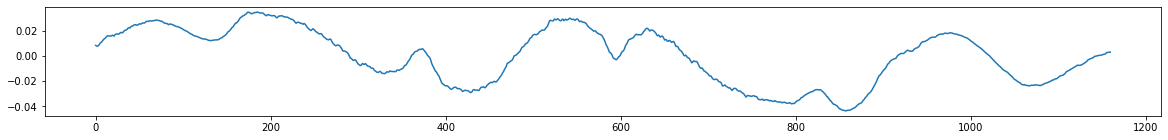

In [5]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

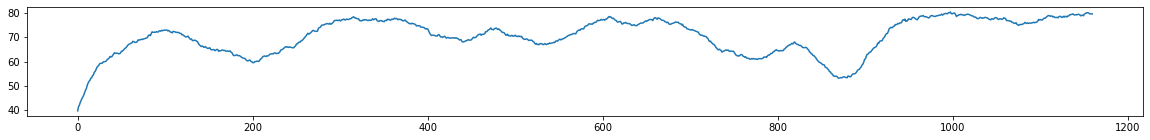

In [6]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [7]:
ix = 600

In [8]:
t = smooth_near_wps(targets[ix])

In [9]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [10]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

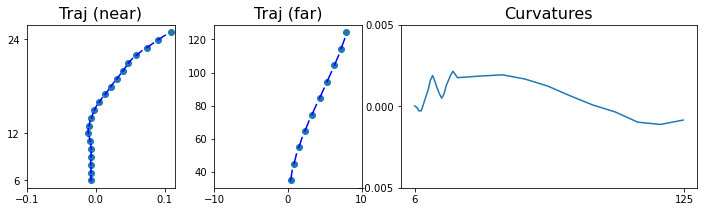

In [11]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

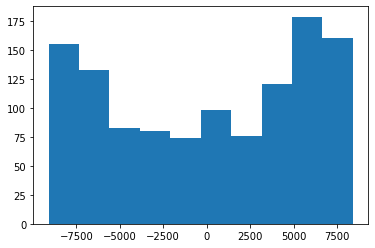

In [12]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

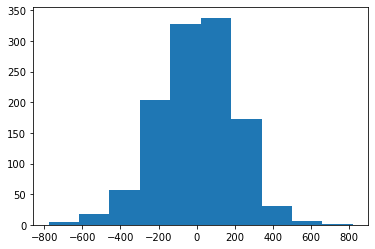

In [13]:
plt.hist(torque[1:]-torque[:-1])[2]

In [14]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [15]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [16]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)
imgs.shape, aux.shape

run_id = "sim"
model_stem = "7.23_avg"
make_vid(run_id, model_stem, imgs, aux, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [17]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 9.3175955,  7.46524  ,  7.2298446,  9.910016 ,  9.26452  ,
       10.231858 ,  9.383629 , 10.096339 ,  9.048296 ,  7.976087 ,
       10.401333 ,  9.882253 ], dtype=float32)

In [18]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 218 out of 360 runs


In [19]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 2.7 s, sys: 166 µs, total: 2.7 s
Wall time: 2.7 s


In [20]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [21]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((142, 1160, 30), (142, 1160, 30), (142, 1160, 30), (142, 1160, 30))

<BarContainer object of 40 artists>

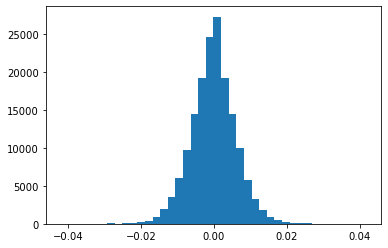

In [22]:
plt.hist(all_curvatures[:,:,2].flatten(), bins=40)[2]

In [23]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

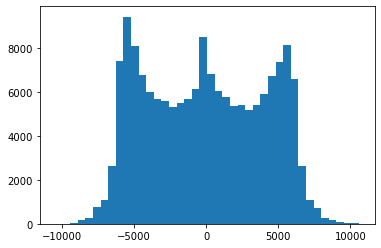

In [24]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

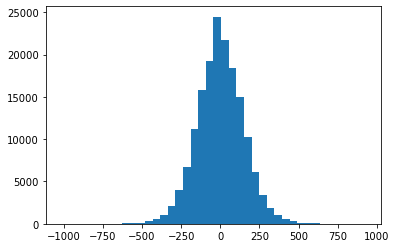

In [25]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [26]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(589.4821551235771, 9088.400058311698)

In [27]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9962616,   6.9955907,   7.9948893,   8.9941225,   9.99331  ,
        10.9924345,  11.991478 ,  12.990446 ,  13.989328 ,  14.988116 ,
        15.986806 ,  16.985352 ,  17.98381  ,  18.982134 ,  19.980259 ,
        20.97827  ,  21.976135 ,  22.97384  ,  23.97139  ,  24.968775 ,
        34.9326   ,  44.875713 ,  54.795387 ,  64.68949  ,  74.55686  ,
        84.397484 ,  94.21195  , 104.00088  , 113.76417  , 123.50342  ],
      dtype=float32)

<BarContainer object of 40 artists>

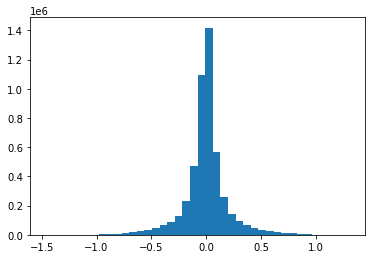

In [28]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [29]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02586662, 0.02990343, 0.0338774 , 0.03785962, 0.04183603,
       0.04580667, 0.04977362, 0.05373885, 0.05769305, 0.06163327,
       0.06556322, 0.06949153, 0.07342204, 0.07730824, 0.08113334,
       0.08487714, 0.08855747, 0.09221285, 0.09586024, 0.09949315,
       0.13482201, 0.16823308, 0.19862676, 0.22555576, 0.24910018,
       0.26983902, 0.28790727, 0.3032863 , 0.31598267, 0.32222304],
      dtype=float32)

In [30]:
mean_headings[-1] / mean_headings[0]

12.457099

In [31]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01546763, 0.01709082, 0.01885082, 0.02068444, 0.02256134,
       0.02446461, 0.02638443, 0.02831553, 0.0302543 , 0.03219695,
       0.03414118, 0.03608415, 0.03802573, 0.03996218, 0.0418901 ,
       0.04380741, 0.04571285, 0.04760759, 0.04949299, 0.05137022,
       0.06984761, 0.08763283, 0.10444815, 0.1201392 , 0.13456129,
       0.14771767, 0.15966703, 0.17043798, 0.18006195, 0.18855123],
      dtype=float32)

In [32]:
mean_angles[-1] / mean_angles[0]

12.190056

In [33]:
mean_angles[0] / .015

1.0311751315991085

<BarContainer object of 40 artists>

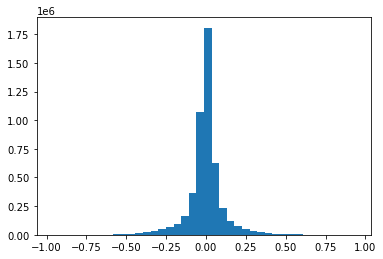

In [34]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

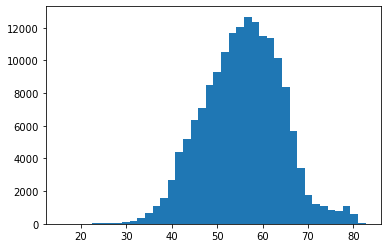

In [35]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]